# Popular Machine Learning Classification Algorithms on Titanic Survivor Dataset

## Data Overview

Source - [Kaggle Titanic Data Set](https://www.kaggle.com/c/titanic/data)

The data has been split into two groups:
- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

Data Dictionary

Variable	Definition	Key

- survival	Survival	0 = No, 1 = Yes

- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

- sex	Sex	

- Age	Age in years	

- sibsp	# of siblings / spouses aboard the Titanic	

- parch	# of parents / children aboard the Titanic	

- ticket	Ticket number	

- fare	Passenger fare	

- cabin	Cabin number	

- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes

- pclass: A proxy for socio-economic status (SES)
 1st = Upper
 2nd = Middle
 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Importing Libraries

In [1]:
import sys

import pandas as pd
import matplotlib
import numpy as np
import scipy as sp

import IPython
from IPython import display

import sklearn

import random
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

## Reading Data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.sample(10), '\n', '*'*50)
print(train.shape,  '\n','*'*50)
print(train.info(), '\n', '*'*50)
print(train.describe(), '\n', '*-'*50)
print(test.sample(10), '\n', '*'*50)
print(test.shape, '\n', '*'*50)
print(test.info(), '\n', '*'*50)
print(test.describe(), '\n', '*'*50)

     PassengerId  Survived  Pclass                                   Name  \
169          170         0       3                          Ling, Mr. Lee   
438          439         0       1                      Fortune, Mr. Mark   
246          247         0       3  Lindahl, Miss. Agda Thorilda Viktoria   
690          691         1       1                Dick, Mr. Albert Adrian   
785          786         0       3     Harmer, Mr. Abraham (David Lishin)   
885          886         0       3   Rice, Mrs. William (Margaret Norton)   
859          860         0       3                       Razi, Mr. Raihed   
284          285         0       1             Smith, Mr. Richard William   
137          138         0       1            Futrelle, Mr. Jacques Heath   
561          562         0       3                      Sivic, Mr. Husein   

        Sex   Age  SibSp  Parch  Ticket      Fare        Cabin Embarked  
169    male  28.0      0      0    1601   56.4958          NaN        S  
438 

In [4]:
data = [train, test]

## Data Pre-Processing

In [5]:
print(train.isnull().sum())
print("*"*20)
print(test.isnull().sum())
final = test[['PassengerId']]

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
********************
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
for dataset in data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    dataset.drop(['PassengerId','Cabin', 'Ticket'], axis = 1, inplace = True)

In [7]:
print(train.isnull().sum())
print("*"*20)
print(test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
********************
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [8]:
for dataset in data:
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split('.', expand = True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = train['Title'].value_counts() < stat_min

train['Title'] = train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train['Title'].value_counts())

title_names = test['Title'].value_counts() < stat_min
test['Title'] = test['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(test['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64


In [9]:
for dataset in data:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtyp

In [10]:
label = LabelEncoder()
for dataset in data:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


Target = ['Survived']

#define x variables for original features aka feature selection
train_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
train_x_c = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
train_xy =  Target + train_x
print('Original X Y: ', train_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
train_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train_xy_bin = Target + train_x_bin
print('Bin X Y: ', train_xy_bin, '\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



## Exploratory Data Analysis

In [11]:
for x in train_x:
    if train[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(train[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*30, '\n')

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
------------------------------ 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
------------------------------ 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
------------------------------ 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
------------------------------ 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
------------------------------ 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000

In [12]:
for x in train_x_bin:
    if train[x].dtype != 'float64' :
        print('Survival by:', x)
        print(train[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*30, '\n')

Survival by: Sex_Code
   Sex_Code  Survived
0         0  0.742038
1         1  0.188908
------------------------------ 

Survival by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
------------------------------ 

Survival by: Embarked_Code
   Embarked_Code  Survived
0              0  0.553571
1              1  0.389610
2              2  0.339009
------------------------------ 

Survival by: Title_Code
   Title_Code  Survived
0           0  0.575000
1           1  0.444444
2           2  0.697802
3           3  0.156673
4           4  0.792000
------------------------------ 

Survival by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
------------------------------ 

Survival by: AgeBin_Code
   AgeBin_Code  Survived
0            0  0.550000
1    

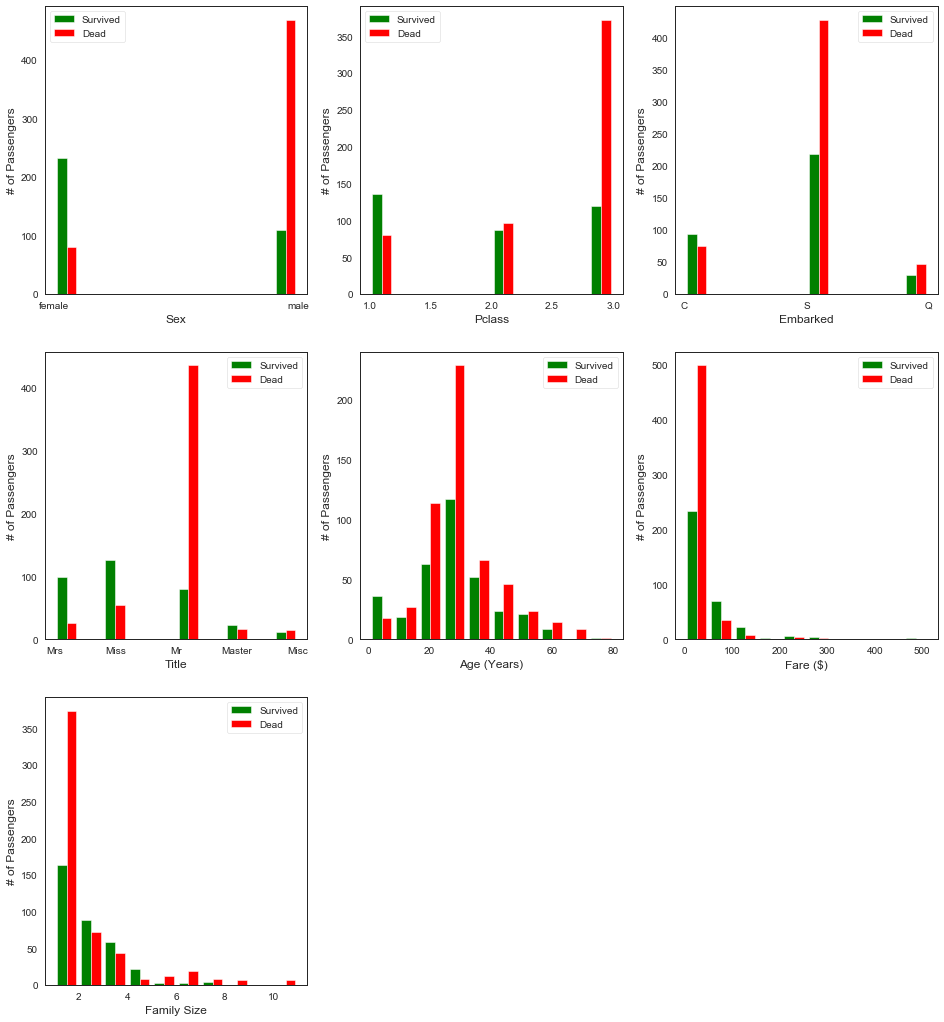

In [13]:
plt.figure(figsize=[16,18])
plt.subplot(331)
plt.hist(x = [train[train['Survived']==1]['Sex'], train[train['Survived']==0]['Sex']], 
          color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Sex')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(332)
plt.hist(x = [train[train['Survived']==1]['Pclass'], train[train['Survived']==0]['Pclass']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Pclass')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(333)
plt.hist(x = [train[train['Survived']==1]['Embarked'], train[train['Survived']==0]['Embarked']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Embarked')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(334)
plt.hist(x = [train[train['Survived']==1]['Title'], train[train['Survived']==0]['Title']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Title')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(335)
plt.hist(x = [train[train['Survived']==1]['Age'], train[train['Survived']==0]['Age']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(336)
plt.hist(x = [train[train['Survived']==1]['Fare'], train[train['Survived']==0]['Fare']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(337)
plt.hist(x = [train[train['Survived']==1]['FamilySize'], train[train['Survived']==0]['FamilySize']], 
         color = ['g','r'],label = ['Survived','Dead'])
plt.xlabel('Family Size')
plt.ylabel('# of Passengers')
plt.legend()
plt.show()

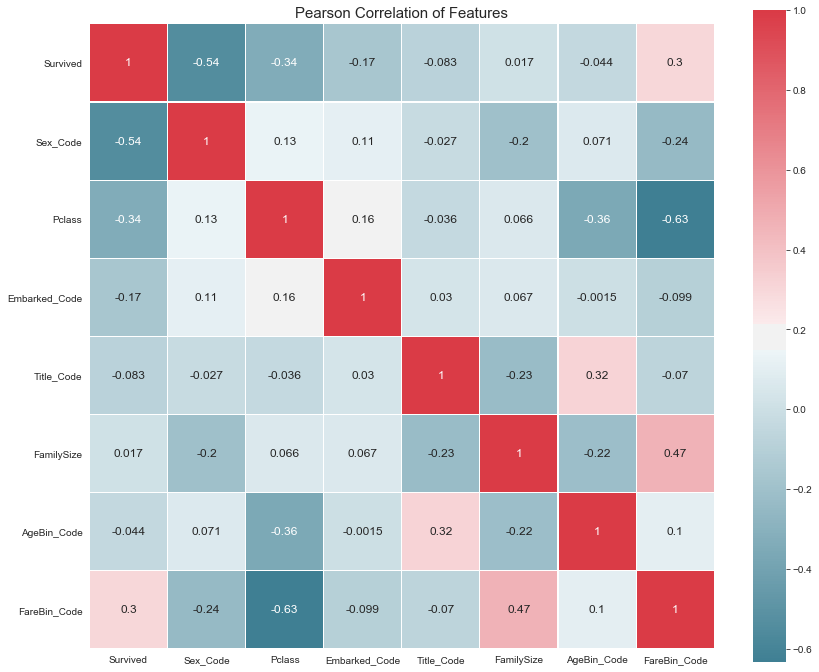

In [14]:
_ , ax = plt.subplots(figsize =(14, 12))
colormap = sns.diverging_palette(220, 10, as_cmap = True)    
a = sns.heatmap(train[train_xy_bin].corr(),cmap = colormap,square=True,ax=ax,annot=True,linewidths=0.1,vmax=1.0, linecolor='white',annot_kws={'fontsize':12 }) 
plt.title('Pearson Correlation of Features', y=1.05, size=15)
a.set_yticklabels(a.get_yticklabels(), rotation=0)
plt.show()

## ML Algorithms Modelling

In [15]:
MLA = [
    ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 5), n_estimators = 100),
    ensemble.RandomForestClassifier(n_estimators = 300, max_depth = 5, min_samples_leaf = 5),
    
    linear_model.LogisticRegression(),
    
    naive_bayes.BernoulliNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(),
    
    tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 5),
    
    XGBClassifier(learning_rate = 0.33, subsample = 0.8, n_estimators = 300, max_depth = 4, gamma = 10)
    ]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

MLA_columns = ['MLA Name','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean']
MLA_compare = pd.DataFrame(columns = MLA_columns)

MLA_predict = train[Target]
MLA_predict_test = pd.DataFrame()
row_index = 0
for alg in MLA:

    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        
    cv_results = model_selection.cross_validate(alg, train[train_x_bin], train[Target], cv  = cv_split,return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   

    alg.fit(train[train_x_bin], train[Target])
    MLA_predict[MLA_name] = alg.predict(train[train_x_bin])
    MLA_predict_test[MLA_name] = alg.predict(test[train_x_bin])
    
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

## Results

In [16]:
MLA_compare

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean
5,SVC,0.835206,0.827612
0,BaggingClassifier,0.851873,0.822761
6,DecisionTreeClassifier,0.847191,0.822015
1,RandomForestClassifier,0.844007,0.820896
7,XGBClassifier,0.828277,0.820149
4,KNeighborsClassifier,0.850375,0.813806
2,LogisticRegression,0.79588,0.789179
3,BernoulliNB,0.785768,0.775373


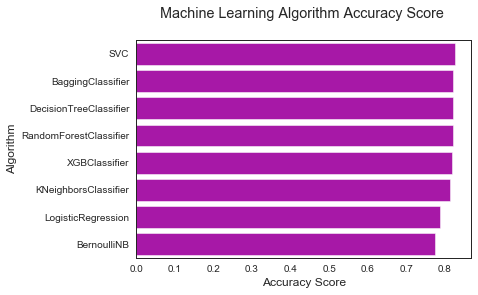

In [17]:
_ = sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

_ = plt.title('Machine Learning Algorithm Accuracy Score \n')
_ = plt.xlabel('Accuracy Score')
_ = plt.ylabel('Algorithm')

In [18]:
MLA_predict_test

,BaggingClassifier,RandomForestClassifier,LogisticRegression,BernoulliNB,KNeighborsClassifier,SVC,DecisionTreeClassifier,XGBClassifier
0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...
413,0,0,0,0,0,0,0,0
414,1,1,1,1,1,1,1,1
415,0,0,0,0,0,0,0,0
416,0,0,0,0,0,0,0,0


In [19]:
cnf_matrix = metrics.confusion_matrix(train['Survived'], MLA_predict['XGBClassifier'])
print(cnf_matrix)

[[492  57]
 [ 90 252]]


In [20]:
a = MLA_predict_test.mode(axis=1)

In [21]:
final['Survived'] = a[0]
final = final.astype(dtype = 'int')
final

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
